# Predicting Flight Delays For Domestic Airlines

### Authors: Ethan Bleier, Elijah Kramer, Roberto Palacios

The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics (BTS) maintains performance records of domestic flights. These statistics include several interesting variables: dates, taxi times, delays, origins, destinations, departure, and arrival times. 

Using data analysis and various machine learning algorithms, this notebook plans to predict whether or not a flight will experience a delay. Specifically, we are interested in which predictors will play the biggest role in causing flight delays.

Our main dataset is taken from [Kaggle](https://www.kaggle.com/datasets/giovamata/airlinedelaycauses/data) and represents data from 2008. However, we expect to find that many of these same patterns found in this dataset to persist today.

In addition to this, we have [airport data]("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat") and [airline data]("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat") taken from [OpenFlights.org](https://openflights.org/) to help fill in gaps in data and previous knowledge.

# TODO:

Take Log10 of delay and use it somehow
Feel free to add more

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### Reading In Data

In [144]:
path = kagglehub.dataset_download("giovamata/airlinedelaycauses")
df = pd.read_csv(path + '/DelayedFlights.csv')
port_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat")
plane_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat")

### Quick plotting settings

In [145]:
sns.set_theme(context='notebook', style='whitegrid')
plt.rcParams['figure.figsize'] = 6, 4

### Data Preprocessing

The airplane and airport data frames need considerable preprocessing before, they can be of us to use. Likewise, our main data frame could use some cleaning before we perform any analysis.

In [146]:
df.drop(["Year", "Unnamed: 0", "DayofMonth", "DayOfWeek"], axis = 1, inplace = True)
df = df.dropna(subset=['DepDelay', 'ArrDelay'])

# Both .dat files need to be formatted properly and new column names are needed
top_row = port_df.columns
port_df.columns = ["AirportId", "Name", "City", "Country", "IATA", "ICAO", "Latitude",
              "Longitude", "Altitude", "Timezone", "DST", "TZ", "Type", "Source"]
port_df.loc[-1] = top_row
port_df.index = port_df.index + 1
port_df = port_df.sort_index()


top_row = plane_df.columns
plane_df.columns = ["AirlineId", "ID", "Name", "IATA", "ICAO", "Callsign",
              "Country", "Active"]
plane_df.loc[-1] = top_row
plane_df.index = plane_df.index + 1
plane_df = plane_df.sort_index()

# plane_df and port_df have columns which we do not need or are of no use so we drop them
port_df = port_df[port_df["Country"] == "United States"]
port_df = port_df[port_df["IATA"] != "\\N"]
port_df.drop(["Source", "ICAO"], axis = 1, inplace = True)

plane_df = plane_df[plane_df["Country"] == "United States"]
plane_df = plane_df.dropna(subset = ["IATA"])
plane_df.drop(["Name", "ICAO"], axis = 1, inplace = True)

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1928371 entries, 0 to 1936757
Data columns (total 26 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Month              int64  
 1   DepTime            float64
 2   CRSDepTime         int64  
 3   ArrTime            float64
 4   CRSArrTime         int64  
 5   UniqueCarrier      object 
 6   FlightNum          int64  
 7   TailNum            object 
 8   ActualElapsedTime  float64
 9   CRSElapsedTime     float64
 10  AirTime            float64
 11  ArrDelay           float64
 12  DepDelay           float64
 13  Origin             object 
 14  Dest               object 
 15  Distance           int64  
 16  TaxiIn             float64
 17  TaxiOut            float64
 18  Cancelled          int64  
 19  CancellationCode   object 
 20  Diverted           int64  
 21  CarrierDelay       float64
 22  WeatherDelay       float64
 23  NASDelay           float64
 24  SecurityDelay      float64
 25  LateAircraftDelay  floa

In [148]:
plane_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229 entries, 10 to 6141
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   AirlineId  229 non-null    object
 1   ID         229 non-null    object
 2   IATA       229 non-null    object
 3   Callsign   169 non-null    object
 4   Country    229 non-null    object
 5   Active     229 non-null    object
dtypes: object(6)
memory usage: 12.5+ KB


In [149]:
port_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1251 entries, 3212 to 7665
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   AirportId  1251 non-null   object
 1   Name       1251 non-null   object
 2   City       1251 non-null   object
 3   Country    1251 non-null   object
 4   IATA       1251 non-null   object
 5   Latitude   1251 non-null   object
 6   Longitude  1251 non-null   object
 7   Altitude   1251 non-null   object
 8   Timezone   1251 non-null   object
 9   DST        1251 non-null   object
 10  TZ         1251 non-null   object
 11  Type       1251 non-null   object
dtypes: object(12)
memory usage: 127.1+ KB


### Initial Data Exploration

While several factors may influence delays, we'd like to examine the constants in this situation rather than rely on chance incidents of weather or unexpected events. As such we'll first be looking at delays in relation to carriers.

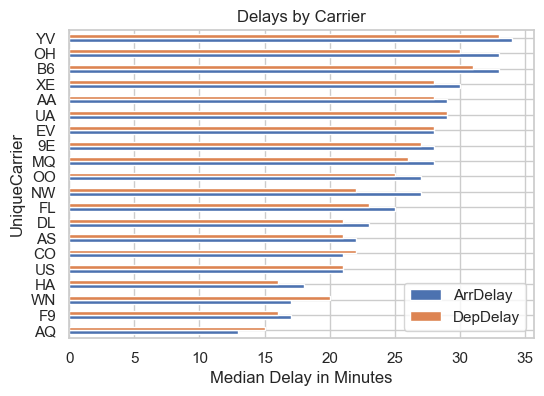

In [150]:
df.groupby("UniqueCarrier")[["ArrDelay", "DepDelay"]].median().sort_values(by ="ArrDelay").plot.barh(title = "Delays by Carrier", xlabel = "Median Delay in Minutes");

This initial analysis suggests that delays are closely tied to carriers. However, we have many more variables to explore. Next, we'll explore the relationship between airports and delays.

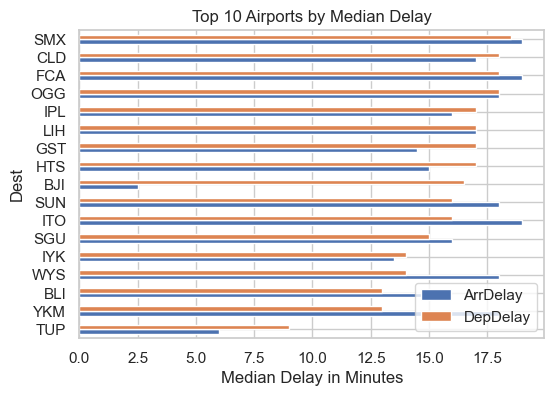

In [151]:
df.groupby("Dest")[["ArrDelay","DepDelay"]].median().sort_values(by = "DepDelay").head(17).plot.barh(title = "Top 10 Airports by Median Delay", xlabel = "Median Delay in Minutes");

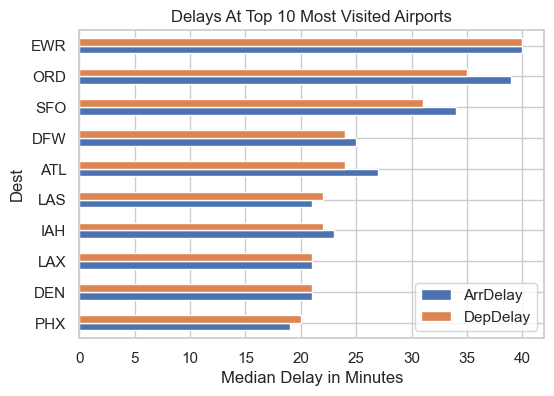

In [170]:
top_ten_airports = df[df["Dest"].isin((df["Dest"].value_counts().head(10)).index)]
top_ten_airports.groupby("Dest")[["ArrDelay","DepDelay"]].median().sort_values(by = "DepDelay").plot.barh();
plt.title("Delays At Top 10 Most Visited Airports")
plt.xlabel("Median Delay in Minutes")
plt.show()

However, looking only at the top 10  most commonly visited airports, a different picture emerges. Here, the disparity in delays between airports is much larger as Newark Liberty International Airport (EWR) has consistent delay times of 40 minutes, while Phoenix Sky Harbor International Airport (PHX) rarely sees delay times higher than half of that. A decrease of 50% is large enough for us to consider airports as an important factor in flight delays.

In [173]:
port_df[port_df["IATA"] == "PHX"]

,AirportId,Name,City,Country,IATA,Latitude,Longitude,Altitude,Timezone,DST,TZ,Type
3263,3462,Phoenix Sky Harbor International Airport,Phoenix,United States,PHX,33.434299,-112.012001,1135,-7,N,America/Phoenix,airport


C:\Users\rpala\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rpala\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

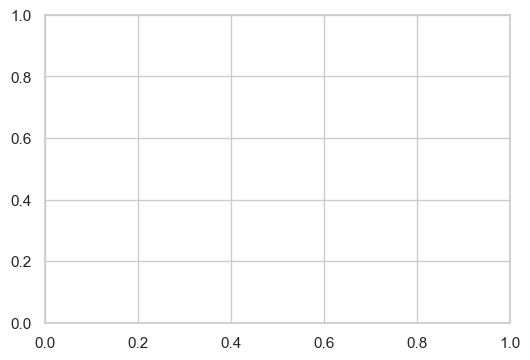

In [176]:
# Checking for outliers
plt.boxplot([df['DepDelay'], df['ArrDelay']])
plt.xticks([1, 2], ['DepDelay', 'ArrDelay'])
plt.show()

from scipy import stats
z_scores = stats.zscore(df[['DepDelay', 'ArrDelay']])
outliers = (abs(z_scores) > 3).any(axis=1)
print("Number of outliers:", outliers.sum())

This plot shows us that there are two many outliers for the mean of the data to provide us with anything useful.

In [ ]:
df_num = df[['ArrDelay', 'DepDelay']]
numeric_vars = df_num.columns.values

from scipy.stats import zscore
zscore1 = lambda s: zscore(s, nan_policy='omit')

df_scaled = df_num.apply(zscore1)

In [ ]:
df_scaled.apply(['min', 'max']).round(2).transpose()

The calculation of the min and max in this instance shows us that some delay values are negative and may indicate either flights that arrived early, or some sort of error.

In [ ]:
sns.pairplot(df_num);

In [ ]:
q01, q99 = df[['DepDelay', 'ArrDelay']].quantile([0.01, 0.99]).values

df['DepDelay'] = df['DepDelay'].clip(q01[0], q99[0])
df['ArrDelay'] = df['ArrDelay'].clip(q01[1], q99[1])

X = StandardScaler().fit_transform(df[['DepDelay', 'ArrDelay']])
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(X)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(df['DepDelay'], df['ArrDelay'], alpha=0.5)
ax1.set_title('Raw Data')
ax1.set_xlabel('Departure Delay')
ax1.set_ylabel('Arrival Delay')

ax2.scatter(df['DepDelay'], df['ArrDelay'], alpha=0.5, c=clusters)
ax2.set_title('Clipped Data with Clusters')
ax2.set_xlabel('Departure Delay')
ax2.set_ylabel('Arrival Delay')

plt.tight_layout()
plt.show()


In [ ]:
z_scores = stats.zscore(df[['DepDelay', 'ArrDelay']])
outliers_removed = df[abs(z_scores).max(axis=1) <= 3]

### Machine Learning

In [ ]:
X = df[['DepDelay', 'ArrDelay']]

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

kmeans = KMeans(n_clusters=3,random_state=0)
cluster_nums = kmeans.fit_predict(X)

Sanity check: Are the clusters too skewed?

In [ ]:
cluster_nums[:100]

print("Cluster 1:", np.bincount(cluster_nums)[0])
print("Cluster 2:", np.bincount(cluster_nums)[1]) 
print("Cluster 3:", np.bincount(cluster_nums)[2])

These clusters seem to expose an acceptable level of skewedness.

In [ ]:
pd.DataFrame(kmeans.cluster_centers_, columns=['RedMeat', 'Fr&Veg'])

I also want to see the clusters

In [ ]:
centers = pd.DataFrame(kmeans.cluster_centers_,
columns=['ArrDelay', 'DepDelay'])

centers.plot.barh()
plt.title('Cluster centers')
plt.xlabel('value'); plt.ylabel('cluster number')
plt.show()

Now in 2D

In [ ]:
cluster_labels = {
    0: 'Low Delay',
    1: 'Medium Delay',
    2: 'High Delay'
}

labels = [cluster_labels[c] for c in clusters]

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, label=labels)
plt.legend(['Low Delay', 'Medium Delay', 'High Delay'])
plt.tight_layout()

In [ ]:
X2 = PCA(n_components=2).fit_transform(X)
ax = sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=cluster_nums,
palette='Set1', s=20, legend=True)
ax.set_title('Flight delays')
ax.set_xlabel('1st principal component')
ax.set_ylabel('2nd principal component');
plt.legend(['Low Delay', 'High Delay', 'Medium Delay']);

I don't think these predictor variable are working out. Im going to try distance and airport.

In [ ]:
df_num = df[['Distance', 'DepDelay']]
numeric_vars = df_num.columns.values

from scipy.stats import zscore
zscore1 = lambda s: zscore(s, nan_policy='omit')

df_scaled = df_num.apply(zscore1)

In [ ]:
airport_stats = df.groupby('Origin').agg({
   'Distance': 'mean',
   'CarrierDelay': 'mean'
}).dropna()

X_scaled = scaler.fit_transform(airport_stats)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0)
airport_stats['Cluster'] = kmeans.fit_predict(X_scaled)

In [ ]:
# Blue is decent, red is bad and blue is good airport
colors = ['#1f77b4', '#d62728', '#2ca02c']  # RGB

plt.scatter(X_scaled[:, 0], X_scaled[:, 1],
           c=[colors[i] for i in airport_stats['Cluster']],
           s=30, alpha=0.3)

distances = np.sqrt(X_scaled[:, 0]**2 + X_scaled[:, 1]**2)
outlier_threshold = np.percentile(distances, 90)  # Top 10% as outliers
outliers = distances > outlier_threshold

for i, txt in enumerate(airport_stats.index):
    if outliers[i]:
        plt.annotate(txt, (X_scaled[i, 0], X_scaled[i, 1]), 
                    fontsize=8, xytext=(5, 5),
                    textcoords='offset points')

plt.xlabel('Average Flight Distance (scaled)')
plt.ylabel('Average Airport Delay (scaled)')
plt.title('Airport Clusters by Distance and Delay')
plt.show();

Next up, let's try using a regression algorithm to predict flight delay. First off, we perform a test/train split on our data. Let's use a test size of 0.15 to preserve a good amount of data for training

In [ ]:
from sklearn.model_selection import train_test_split

X = df['DepDelay']
y = df['Distance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

print(f'Using {X_train.shape[0]} samples for training and {X_test.shape[0]} for testing')